# Public Relations: Predict if customers are satisfied through sentiment analysis

### Author: Harry Patterson

                                ====================================================

## Table of Contents

### The Overview
- [Customers happy or not?](#problem)
- [Predict Satisfaction](#objective)

### Data Quality Check
- [Simple Inspection of Data](#Check)

### Explortory Data Analysis
- [Explore Dataset](#eda1)
- [Create a length column](#eda2)
- [Examine Positive Reviews](#eda3)
- [Examine Negative Reviews](#eda4)
- [Examine Ratings](#EDA5)
- [Examine Variation](#EDA6)
- [Plot Wordcloud](#EDA7)

### Data Cleaning
- [Data Cleaning](#DC)
- [Remove Punctuation](#RP)
- [Remove Stopwords](#RS)
- [Preform Tokenization](#PT)
- [Text Cleaning](#TC)

### Model Training
- [Naive Bayes](#NB)
- [Evaluate Naive Bayes](#ENB)
- [Logistic Regression](#LR)
- [Evaluate Logistic Regression](#ELG)

***

<a id='problem'></a>
# The Problem

- This corporation need to know if customers are saying positive or negative things about their products which in this case is Amazon Echo.  

***

<a id='objective'></a>
# The Objective

- Perform sentiment analysis on reviews (Amazon Echo) and social media posts and use Machine Learning models to predict whether or not customers are happy or not. 

***

## IMPORT LIBRARIES

In [191]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harrypatterson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read the Data

In [111]:

reviews_df = pd.read_csv('Data/amazon_alexa.tsv', delimiter = '\t', quoting = 3)
reviews_df

rating       date         variation  \
0          5  31-Jul-18  Charcoal Fabric    
1          5  31-Jul-18  Charcoal Fabric    
2          4  31-Jul-18    Walnut Finish    
3          5  31-Jul-18  Charcoal Fabric    
4          5  31-Jul-18  Charcoal Fabric    
...      ...        ...               ...   
3145       5  30-Jul-18        Black  Dot   
3146       5  30-Jul-18        Black  Dot   
3147       5  30-Jul-18        Black  Dot   
3148       5  30-Jul-18        White  Dot   
3149       4  29-Jul-18        Black  Dot   

                                       verified_reviews  feedback  
0                                         Love my Echo!         1  
1                                             Loved it!         1  
2     "Sometimes while playing a game, you can answe...         1  
3     "I have had a lot of fun with this thing. My 4...         1  
4                                                 Music         1  
...                                                 ...       ...  
3145  "Perfect for kids, adults and everyone in betw...         1  
3146  "Listening to music, searching locations, chec...         1  
3147  "I do love these things, i have them running m...         1  
3148  "Only complaint I have is that the sound quali...         1  
3149                                               Good         1  

[3150 rows x 5 columns]

<a id='Check'></a>
# Data Quality Check
***

In [112]:
reviews_df.shape

(3150, 5)

In [113]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [114]:
reviews_df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [115]:
reviews_df.describe()

rating     feedback
count  3150.000000  3150.000000
mean      4.463175     0.918413
std       1.068506     0.273778
min       1.000000     0.000000
25%       4.000000     1.000000
50%       5.000000     1.000000
75%       5.000000     1.000000
max       5.000000     1.000000

In [116]:
reviews_df.describe(include='O')

date   variation verified_reviews
count        3150        3150             3150
unique         77          16             2301
top     30-Jul-18  Black  Dot                 
freq         1603         516               79

In [117]:
# Finding the count of each class of dependent variable 
# 0 - Did sign 

print(sum(reviews_df['feedback'] == 1))
print(sum(reviews_df['feedback'] == 0))

2893
257


<AxesSubplot:xlabel='feedback', ylabel='count'>

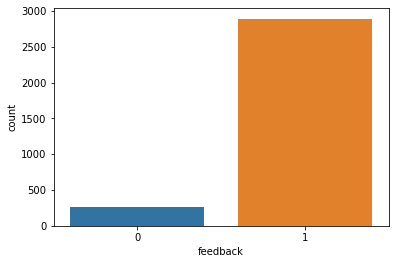

In [118]:
# sns.countplot(reviews_df['feedback'],label = 'Count')
sns.countplot(data = reviews_df, x = 'feedback', label = "Count")

In [119]:
print('Number of duplicated records: ', reviews_df.duplicated().sum())

Number of duplicated records:  715


### Results 

- I see that most of these customers are satisfied with their echo which includes an average rating of 4.5.
- Notice that there are a lot of duplicates within this dataset. 
- Feedback is almost at a one average which means most feedback contains a positive review

***

<a id='eda1'></a>
# Exploratory Data Analysis
***

In [120]:
# just a quick glance
reviews_df['verified_reviews']

0                                           Love my Echo!
1                                               Loved it!
2       "Sometimes while playing a game, you can answe...
3       "I have had a lot of fun with this thing. My 4...
4                                                   Music
                              ...                        
3145    "Perfect for kids, adults and everyone in betw...
3146    "Listening to music, searching locations, chec...
3147    "I do love these things, i have them running m...
3148    "Only complaint I have is that the sound quali...
3149                                                 Good
Name: verified_reviews, Length: 3150, dtype: object

array([[<AxesSubplot:title={'center':'rating'}>,
        <AxesSubplot:title={'center':'feedback'}>]], dtype=object)

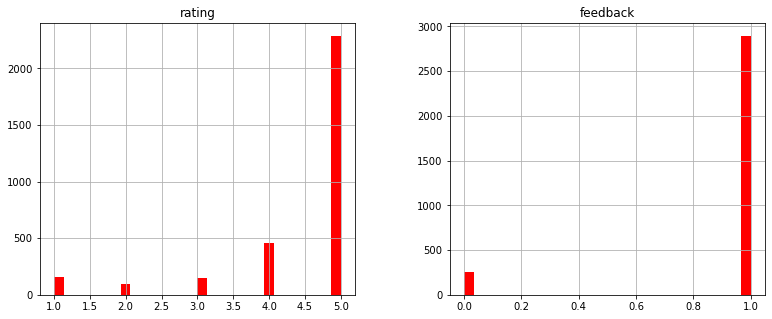

In [121]:
# histogram

reviews_df.hist(bins=30, figsize=(13,5), color = 'r')

<a id='eda2'></a>
# Examine The Amount Of Characters In Verified Reviews. 
***

In [122]:
# See how many characters or in the reviews column

reviews_df['length'] = reviews_df['verified_reviews'].apply(len)
reviews_df

rating       date         variation  \
0          5  31-Jul-18  Charcoal Fabric    
1          5  31-Jul-18  Charcoal Fabric    
2          4  31-Jul-18    Walnut Finish    
3          5  31-Jul-18  Charcoal Fabric    
4          5  31-Jul-18  Charcoal Fabric    
...      ...        ...               ...   
3145       5  30-Jul-18        Black  Dot   
3146       5  30-Jul-18        Black  Dot   
3147       5  30-Jul-18        Black  Dot   
3148       5  30-Jul-18        White  Dot   
3149       4  29-Jul-18        Black  Dot   

                                       verified_reviews  feedback  length  
0                                         Love my Echo!         1      13  
1                                             Loved it!         1       9  
2     "Sometimes while playing a game, you can answe...         1     197  
3     "I have had a lot of fun with this thing. My 4...         1     174  
4                                                 Music         1       5  
...                                                 ...       ...     ...  
3145  "Perfect for kids, adults and everyone in betw...         1      52  
3146  "Listening to music, searching locations, chec...         1     137  
3147  "I do love these things, i have them running m...         1     443  
3148  "Only complaint I have is that the sound quali...         1     382  
3149                                               Good         1       4  

[3150 rows x 6 columns]

<AxesSubplot:ylabel='Frequency'>

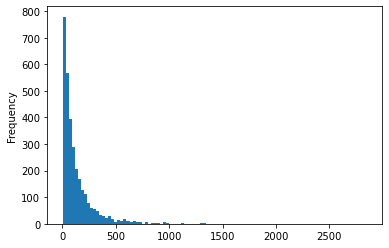

In [123]:
# Plot histogram for length column 

reviews_df['length'].plot(bins=100, kind = 'hist')

In [124]:
# See which rows have the shortest, longest and mean in the length column

reviews_df.length.describe()

count    3150.000000
mean      132.673651
std       182.526953
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

In [125]:
# See which row have the longest amount of characters 

reviews_df[reviews_df['length'] == 2853]['verified_reviews'].iloc[0]

'"Incredible piece of technology.I have this right center of my living room on an island kitchen counter. The mic and speaker goes in every direction and the quality of the sound is quite good. I connected the Echo via Bluetooth to my Sony soundbar on my TV but find the Echo placement and 360 sound more appealing. It\'s no audiophile equipment but there is good range and decent bass. The sound is more than adequate for any indoor entertaining and loud enough to bother neighbors in my building. The knob on the top works great for adjusting volume. This is my first Echo device and I would imagine having to press volume buttons (on the Echo 2) a large inconvenience and not as precise. For that alone I would recommend this over the regular Echo (2nd generation).The piece looks quality and is quite sturdy with some weight on it. The rubber material on the bottom has a good grip on the granite counter-- my cat can even rub her scent on it without tipping it over.This order came with a free P

In [126]:
# See which row have the shortest amount of characters 

reviews_df[reviews_df['length'] == 1]['verified_reviews'].iloc[0]

'😍'

In [127]:
# See the average of the length column

reviews_df[reviews_df['length'] == 132]['verified_reviews'].iloc[0]

'"We love having this in our kitchen! Very convenient to look up recipes, listen to the news, or watch prime video while I\'m cooking"'

### Results 

- We can see most of the reviews are very short but there are some that reach over a 1000 characters which I can assume the customer is extremly satisfied or extremely dissappointed. 

***

<a id='eda3'></a>
# Examine Positive Reviews. 
***

In [128]:
# Create a dataframe

positive = reviews_df[reviews_df['feedback'] == 1]
positive

rating       date         variation  \
0          5  31-Jul-18  Charcoal Fabric    
1          5  31-Jul-18  Charcoal Fabric    
2          4  31-Jul-18    Walnut Finish    
3          5  31-Jul-18  Charcoal Fabric    
4          5  31-Jul-18  Charcoal Fabric    
...      ...        ...               ...   
3145       5  30-Jul-18        Black  Dot   
3146       5  30-Jul-18        Black  Dot   
3147       5  30-Jul-18        Black  Dot   
3148       5  30-Jul-18        White  Dot   
3149       4  29-Jul-18        Black  Dot   

                                       verified_reviews  feedback  length  
0                                         Love my Echo!         1      13  
1                                             Loved it!         1       9  
2     "Sometimes while playing a game, you can answe...         1     197  
3     "I have had a lot of fun with this thing. My 4...         1     174  
4                                                 Music         1       5  
...                                                 ...       ...     ...  
3145  "Perfect for kids, adults and everyone in betw...         1      52  
3146  "Listening to music, searching locations, chec...         1     137  
3147  "I do love these things, i have them running m...         1     443  
3148  "Only complaint I have is that the sound quali...         1     382  
3149                                               Good         1       4  

[2893 rows x 6 columns]

<AxesSubplot:ylabel='count'>

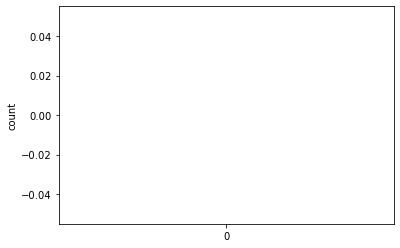

In [129]:
sns.countplot()

### Results 

-

***

<a id='eda4'></a>
# Examine Negative Reviews. 
***

In [130]:
negative = reviews_df[reviews_df['feedback'] == 0]
negative

rating       date             variation  \
46         2  30-Jul-18      Charcoal Fabric    
111        2  30-Jul-18      Charcoal Fabric    
141        1  30-Jul-18      Charcoal Fabric    
162        1  30-Jul-18     Sandstone Fabric    
176        2  30-Jul-18  Heather Gray Fabric    
...      ...        ...                   ...   
3047       1  30-Jul-18            Black  Dot   
3048       1  30-Jul-18            White  Dot   
3067       2  30-Jul-18            Black  Dot   
3091       1  30-Jul-18            Black  Dot   
3096       1  30-Jul-18            White  Dot   

                                       verified_reviews  feedback  length  
46    "It's like Siri, in fact, Siri answers more ac...         0     165  
111   Sound is terrible if u want good music too get...         0      53  
141                                  Not much features.         0      18  
162   "Stopped working after 2 weeks ,didn't follow ...         0      89  
176                                Sad joke. Worthless.         0      20  
...                                                 ...       ...     ...  
3047  Echo Dot responds to us when we aren't even ta...         0     120  
3048              NOT CONNECTED TO MY PHONE PLAYLIST :(         0      37  
3067  The only negative we have on this product is t...         0     240  
3091                                  I didn’t order it         0      17  
3096  The product sounded the same as the emoji spea...         0     210  

[257 rows x 6 columns]

### Results 

- I can see the key words that are considered negative reviews in the verified_reviews

***

<a id='EDA5'></a>
# Examine Ratings
***

<AxesSubplot:xlabel='rating', ylabel='count'>

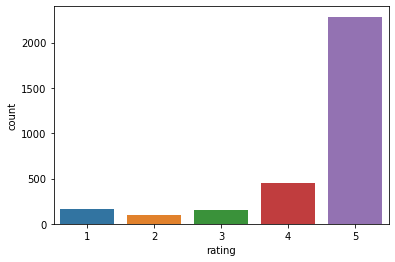

In [131]:
# sns.countplot(reviews_df['feedback'],label = 'Count')
sns.countplot(data = reviews_df, x = 'rating', label = "Count")

### Results 

- Verifies that much of the data provided gives a 4 rating or higher. 

***

<a id='EDA6'></a>
# Examine variation

- See if there is any relationship between other features. 
- Example: See if customers prefer a certain variation over the other. 
***

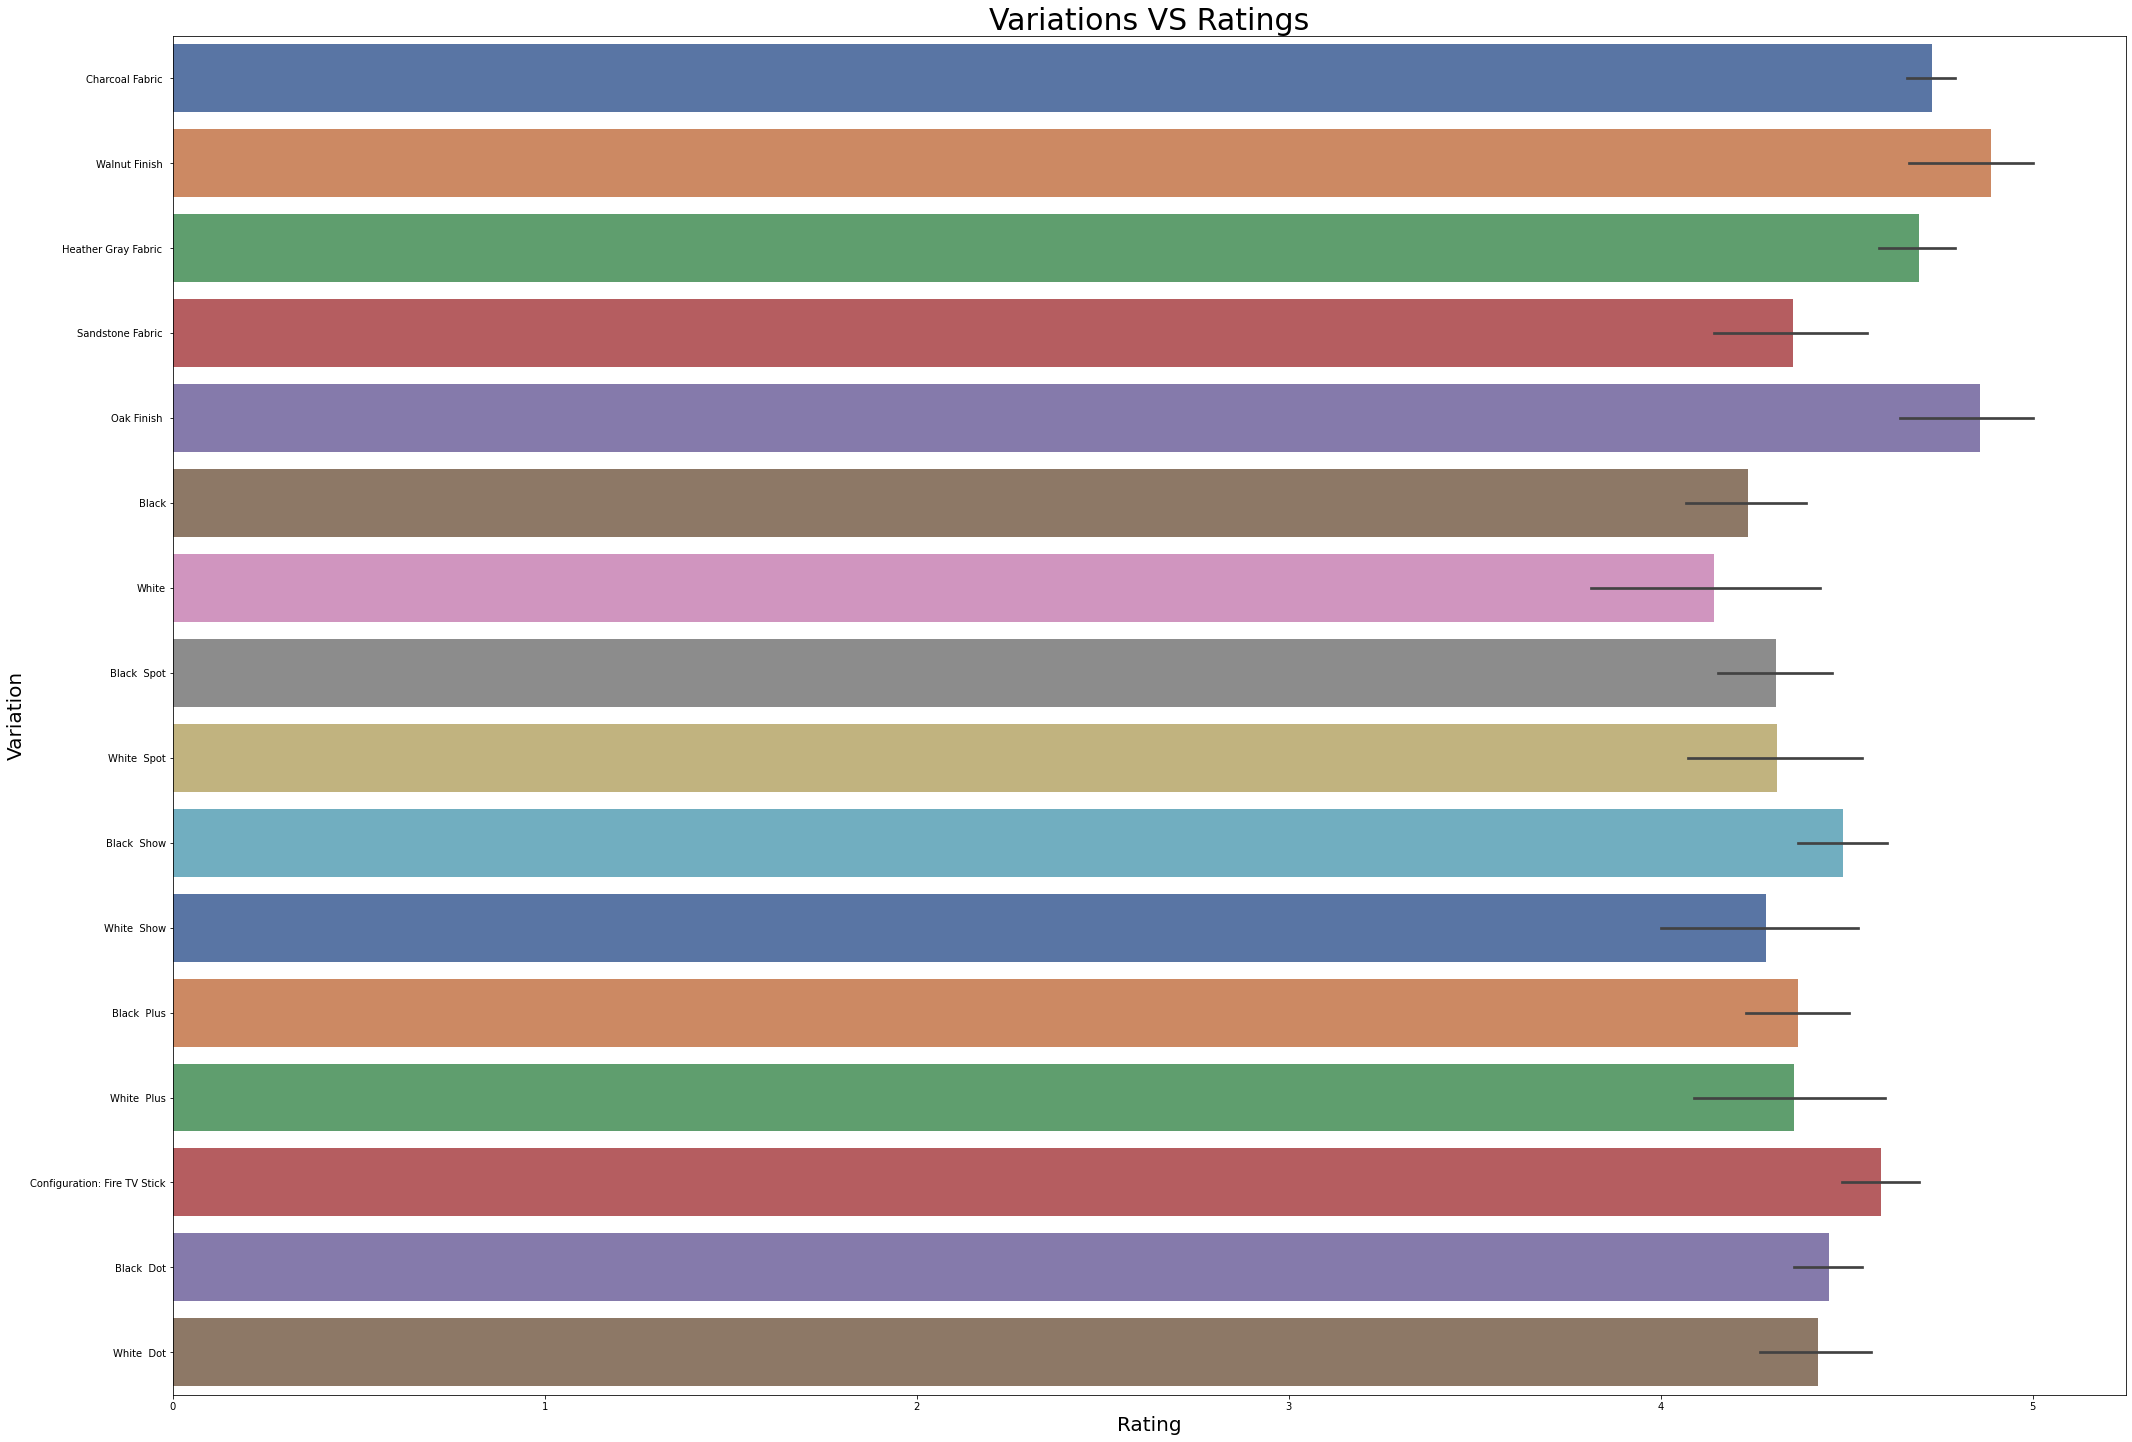

In [132]:
# Set figure size (width, height) in inches
fig, ax = plt.subplots(figsize = (35 , 25 ))
  
# Plot the barplot
sns.barplot( ax = ax , x = 'rating', y = 'variation' , data = reviews_df, palette='deep')
  
# Set label for x-axis
ax.set_xlabel( "Rating" , size = 20)
  
# Set label for y-axis
ax.set_ylabel( "Variation" , size = 20 )
  
# Set title for plot
ax.set_title( "Variations VS Ratings" , size = 30)
  
# Display figure
plt.show()

### Results 

- Rating is pretty consistent but do notice, maybe the white variation is not liked as much and the walnut finish is liked the most. 
- Maybe the variation have an effect on the rating
***

<a id='EDA7'></a>
# Plot Wordcloud

- Most Prominent words the customers are using
- Visually see all, positive and negative reviews 
***

In [133]:
# Convert dataframe to list
sentences = reviews_df['verified_reviews'].tolist()
sentences

['Love my Echo!',
 'Loved it!',
 '"Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home."',
 '"I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well."',
 'Music',
 '"I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do."',
 '"Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet."',
 "I think this is the 5th 

In [134]:
# Connect all the sentences

sentences_as_one_string = ' '.join(sentences)     # Join sentences based off spaces
sentences_as_one_string

'Love my Echo! Loved it! "Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home." "I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well." Music "I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do." "Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet." I think this is the 5th one I\'ve purchased. I\'m wor

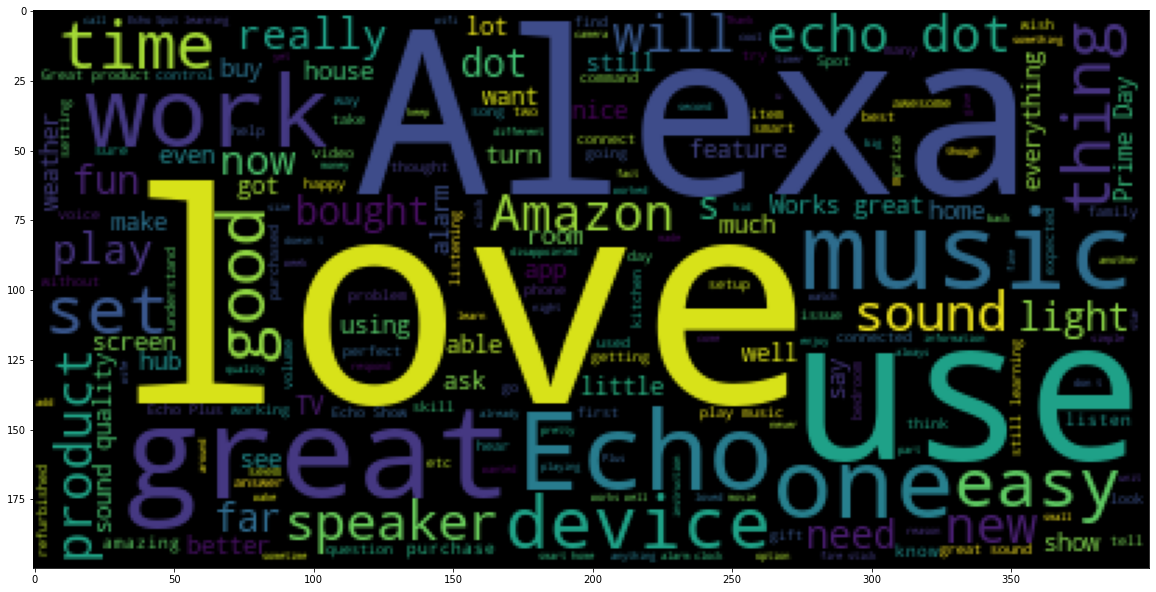

In [135]:
plt.figure(figsize = (20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string))

### Create Positive Word Cloud 

In [136]:
positive

rating       date         variation  \
0          5  31-Jul-18  Charcoal Fabric    
1          5  31-Jul-18  Charcoal Fabric    
2          4  31-Jul-18    Walnut Finish    
3          5  31-Jul-18  Charcoal Fabric    
4          5  31-Jul-18  Charcoal Fabric    
...      ...        ...               ...   
3145       5  30-Jul-18        Black  Dot   
3146       5  30-Jul-18        Black  Dot   
3147       5  30-Jul-18        Black  Dot   
3148       5  30-Jul-18        White  Dot   
3149       4  29-Jul-18        Black  Dot   

                                       verified_reviews  feedback  length  
0                                         Love my Echo!         1      13  
1                                             Loved it!         1       9  
2     "Sometimes while playing a game, you can answe...         1     197  
3     "I have had a lot of fun with this thing. My 4...         1     174  
4                                                 Music         1       5  
...                                                 ...       ...     ...  
3145  "Perfect for kids, adults and everyone in betw...         1      52  
3146  "Listening to music, searching locations, chec...         1     137  
3147  "I do love these things, i have them running m...         1     443  
3148  "Only complaint I have is that the sound quali...         1     382  
3149                                               Good         1       4  

[2893 rows x 6 columns]

In [137]:
positive_list = positive['verified_reviews'].tolist()
positive_list

['Love my Echo!',
 'Loved it!',
 '"Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home."',
 '"I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well."',
 'Music',
 '"I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do."',
 '"Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet."',
 "I think this is the 5th 

In [138]:
# Connect all the sentences

positive_as_one_string = ' '.join(positive_list)     # Join sentences based off spaces
positive_as_one_string

'Love my Echo! Loved it! "Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home." "I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well." Music "I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do." "Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet." I think this is the 5th one I\'ve purchased. I\'m wor

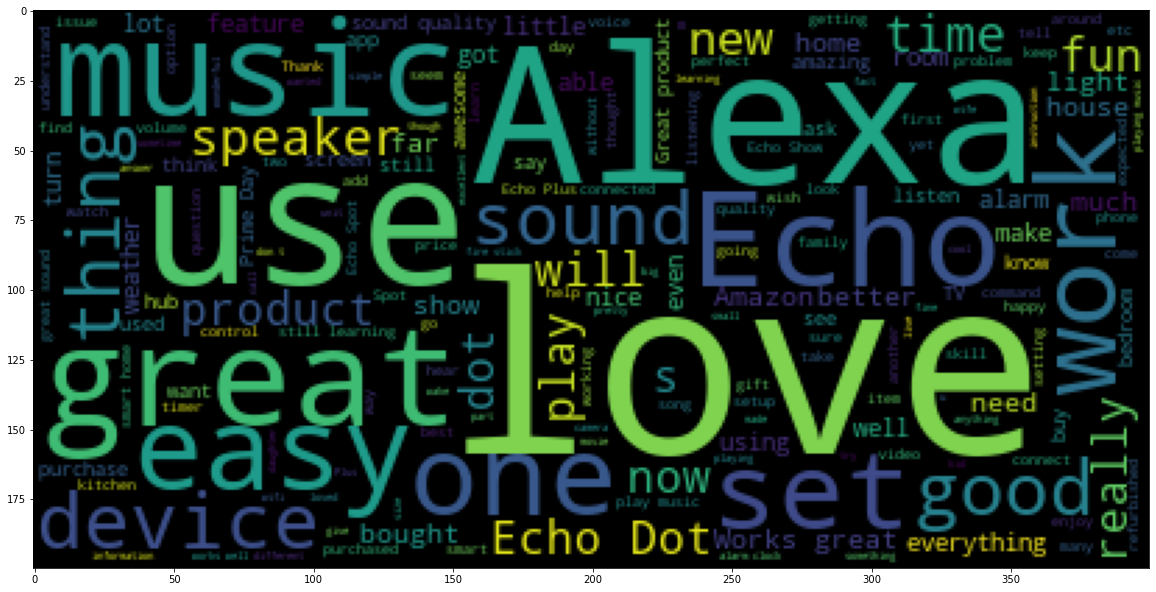

In [139]:
plt.figure(figsize = (20,20))
plt.imshow(WordCloud().generate(positive_as_one_string))

### Create Negative Word Cloud 

In [140]:
negative

rating       date             variation  \
46         2  30-Jul-18      Charcoal Fabric    
111        2  30-Jul-18      Charcoal Fabric    
141        1  30-Jul-18      Charcoal Fabric    
162        1  30-Jul-18     Sandstone Fabric    
176        2  30-Jul-18  Heather Gray Fabric    
...      ...        ...                   ...   
3047       1  30-Jul-18            Black  Dot   
3048       1  30-Jul-18            White  Dot   
3067       2  30-Jul-18            Black  Dot   
3091       1  30-Jul-18            Black  Dot   
3096       1  30-Jul-18            White  Dot   

                                       verified_reviews  feedback  length  
46    "It's like Siri, in fact, Siri answers more ac...         0     165  
111   Sound is terrible if u want good music too get...         0      53  
141                                  Not much features.         0      18  
162   "Stopped working after 2 weeks ,didn't follow ...         0      89  
176                                Sad joke. Worthless.         0      20  
...                                                 ...       ...     ...  
3047  Echo Dot responds to us when we aren't even ta...         0     120  
3048              NOT CONNECTED TO MY PHONE PLAYLIST :(         0      37  
3067  The only negative we have on this product is t...         0     240  
3091                                  I didn’t order it         0      17  
3096  The product sounded the same as the emoji spea...         0     210  

[257 rows x 6 columns]

In [141]:
negative_list = negative['verified_reviews'].tolist()
negative_list

['"It\'s like Siri, in fact, Siri answers more accurately then Alexa.  I don\'t see a real need for it in my household, though it was a good bargain on prime day deals."',
 'Sound is terrible if u want good music too get a bose',
 'Not much features.',
 '"Stopped working after 2 weeks ,didn\'t follow commands!? Really fun when it was working?"',
 'Sad joke. Worthless.',
 '"Really disappointed Alexa has to be plug-in to wall socket all the time.  My fault for not checking this, but made the assumption that a company has technologically advanced as Amazon would sell this product with a rechargeable battery.  If I could return it, I would as my Apple music and boom speaker give me more flexibility the Alexa."',
 "It's got great sound and bass but it doesn't work all of the time. Its still hot or miss when it recognizes things",
 '"I am not super impressed with Alexa. When my Prime lapsed, she wouldn\'t play anything. She isn\'t smart enough to differentiate among spotify accounts so we ca

In [142]:
# Connect all the sentences

negative_as_one_string = ' '.join(negative_list)     # Join sentences based off spaces
negative_as_one_string

'"It\'s like Siri, in fact, Siri answers more accurately then Alexa.  I don\'t see a real need for it in my household, though it was a good bargain on prime day deals." Sound is terrible if u want good music too get a bose Not much features. "Stopped working after 2 weeks ,didn\'t follow commands!? Really fun when it was working?" Sad joke. Worthless. "Really disappointed Alexa has to be plug-in to wall socket all the time.  My fault for not checking this, but made the assumption that a company has technologically advanced as Amazon would sell this product with a rechargeable battery.  If I could return it, I would as my Apple music and boom speaker give me more flexibility the Alexa." It\'s got great sound and bass but it doesn\'t work all of the time. Its still hot or miss when it recognizes things "I am not super impressed with Alexa. When my Prime lapsed, she wouldn\'t play anything. She isn\'t smart enough to differentiate among spotify accounts so we can\'t use it for that either

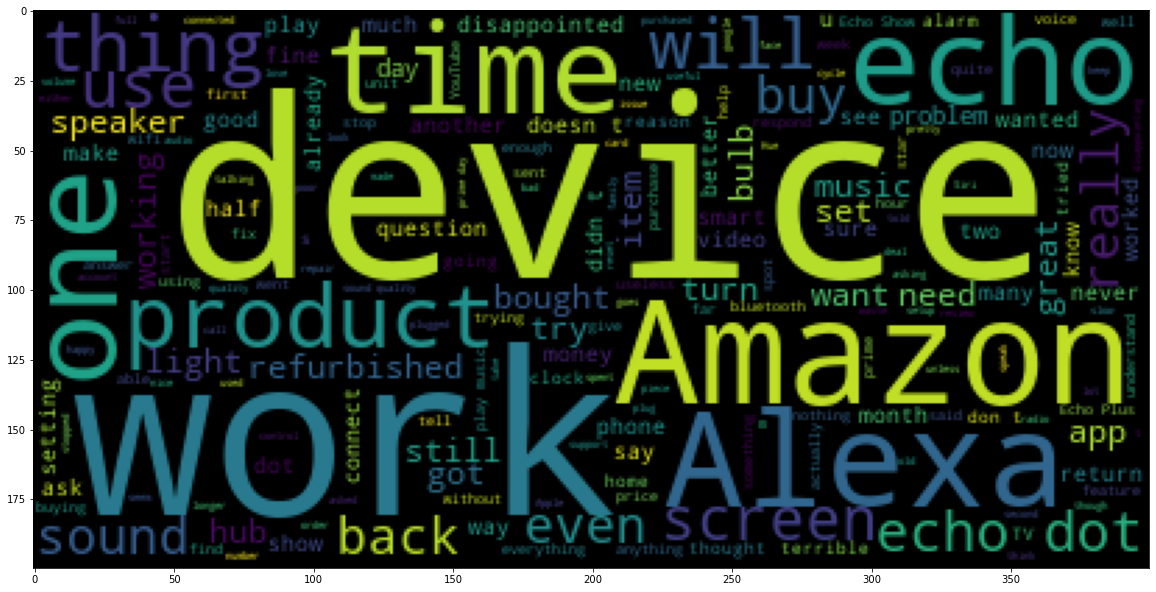

In [143]:
plt.figure(figsize = (20,20))
plt.imshow(WordCloud().generate(negative_as_one_string))

### Results 

- I can quickly see that from all the words in the dataset words such as love, Alexa, music, great etc. are used the most which seems correct. 
- Looking at the positive word cloud Words like love and great seems to be used the most. 
- Looking at the negative word cloud the general words are used the most but Words like disappointed, refurbished and problem can be seen.
- Can try to remove some common words to better the wordcloud such as device, echo, alexa etc.  


***

<a id='DC'></a>
# Data cleaning to prepare data for ML algorithms.  
***

In [144]:
# Drop the date and ratings 

reviews_df.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  length  
0                                      Love my Echo!         1      13  
1                                          Loved it!         1       9  
2  "Sometimes while playing a game, you can answe...         1     197  
3  "I have had a lot of fun with this thing. My 4...         1     174  
4                                              Music         1       5

In [145]:
reviews_df = reviews_df.drop(['date','rating','length'], axis = 1)
reviews_df

variation                                   verified_reviews  \
0     Charcoal Fabric                                       Love my Echo!   
1     Charcoal Fabric                                           Loved it!   
2       Walnut Finish   "Sometimes while playing a game, you can answe...   
3     Charcoal Fabric   "I have had a lot of fun with this thing. My 4...   
4     Charcoal Fabric                                               Music   
...                ...                                                ...   
3145        Black  Dot  "Perfect for kids, adults and everyone in betw...   
3146        Black  Dot  "Listening to music, searching locations, chec...   
3147        Black  Dot  "I do love these things, i have them running m...   
3148        White  Dot  "Only complaint I have is that the sound quali...   
3149        Black  Dot                                               Good   

      feedback  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
3145         1  
3146         1  
3147         1  
3148         1  
3149         1  

[3150 rows x 3 columns]

In [146]:
# Convert categorical variables (one-hot encoding)
# Drop first column to avoid dummy variable trap: Occurs when you have two columns and 1 column can be predicted from the other one.

variation_dummies = pd.get_dummies(reviews_df['variation'], drop_first=True)

In [147]:
variation_dummies

Black  Dot  Black  Plus  Black  Show  Black  Spot  Charcoal Fabric   \
0              0            0            0            0                 1   
1              0            0            0            0                 1   
2              0            0            0            0                 0   
3              0            0            0            0                 1   
4              0            0            0            0                 1   
...          ...          ...          ...          ...               ...   
3145           1            0            0            0                 0   
3146           1            0            0            0                 0   
3147           1            0            0            0                 0   
3148           0            0            0            0                 0   
3149           1            0            0            0                 0   

      Configuration: Fire TV Stick  Heather Gray Fabric   Oak Finish   \
0                                0                     0            0   
1                                0                     0            0   
2                                0                     0            0   
3                                0                     0            0   
4                                0                     0            0   
...                            ...                   ...          ...   
3145                             0                     0            0   
3146                             0                     0            0   
3147                             0                     0            0   
3148                             0                     0            0   
3149                             0                     0            0   

      Sandstone Fabric   Walnut Finish   White  White  Dot  White  Plus  \
0                     0               0      0           0            0   
1                     0               0      0           0            0   
2                     0               1      0           0            0   
3                     0               0      0           0            0   
4                     0               0      0           0            0   
...                 ...             ...    ...         ...          ...   
3145                  0               0      0           0            0   
3146                  0               0      0           0            0   
3147                  0               0      0           0            0   
3148                  0               0      0           1            0   
3149                  0               0      0           0            0   

      White  Show  White  Spot  
0               0            0  
1               0            0  
2               0            0  
3               0            0  
4               0            0  
...           ...          ...  
3145            0            0  
3146            0            0  
3147            0            0  
3148            0            0  
3149            0            0  

[3150 rows x 15 columns]

In [148]:
# Drop variation because we do not need anymore
reviews_df.drop(['variation'],axis = 1, inplace=True)

In [149]:
# Join dataframes 

reviews_df = pd.concat([reviews_df, variation_dummies], axis = 1)
reviews_df

verified_reviews  feedback  Black  Dot  \
0                                         Love my Echo!         1           0   
1                                             Loved it!         1           0   
2     "Sometimes while playing a game, you can answe...         1           0   
3     "I have had a lot of fun with this thing. My 4...         1           0   
4                                                 Music         1           0   
...                                                 ...       ...         ...   
3145  "Perfect for kids, adults and everyone in betw...         1           1   
3146  "Listening to music, searching locations, chec...         1           1   
3147  "I do love these things, i have them running m...         1           1   
3148  "Only complaint I have is that the sound quali...         1           0   
3149                                               Good         1           1   

      Black  Plus  Black  Show  Black  Spot  Charcoal Fabric   \
0               0            0            0                 1   
1               0            0            0                 1   
2               0            0            0                 0   
3               0            0            0                 1   
4               0            0            0                 1   
...           ...          ...          ...               ...   
3145            0            0            0                 0   
3146            0            0            0                 0   
3147            0            0            0                 0   
3148            0            0            0                 0   
3149            0            0            0                 0   

      Configuration: Fire TV Stick  Heather Gray Fabric   Oak Finish   \
0                                0                     0            0   
1                                0                     0            0   
2                                0                     0            0   
3                                0                     0            0   
4                                0                     0            0   
...                            ...                   ...          ...   
3145                             0                     0            0   
3146                             0                     0            0   
3147                             0                     0            0   
3148                             0                     0            0   
3149                             0                     0            0   

      Sandstone Fabric   Walnut Finish   White  White  Dot  White  Plus  \
0                     0               0      0           0            0   
1                     0               0      0           0            0   
2                     0               1      0           0            0   
3                     0               0      0           0            0   
4                     0               0      0           0            0   
...                 ...             ...    ...         ...          ...   
3145                  0               0      0           0            0   
3146                  0               0      0           0            0   
3147                  0               0      0           0            0   
3148                  0               0      0           1            0   
3149                  0               0      0           0            0   

      White  Show  White  Spot  
0               0            0  
1               0            0  
2               0            0  
3               0            0  
4               0            0  
...           ...          ...  
3145            0            0  
3146            0            0  
3147            0            0  
3148            0            0  
3149            0            0  

[3150 rows x 17 columns]

### Results 

- Create dummies for categorical features and drop columns not needed. 

***

# Trying way from video (may keep)

In [152]:
# Create function to remove punctuation, and remove stopwoords. 

def message_cleaning(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return Test_punc_removed_join_clean

In [153]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [154]:
# Add additional stopwords from nltk (looked throught data)

stop_words = stopwords.words('english')
stop_words.extend(['music','alexa','echo','amazon','device', 'product','dot',])

In [155]:
reviews_clean_df = reviews_df['verified_reviews'].apply(message_cleaning)
reviews_clean_df

0                                            [Love, Echo]
1                                                 [Loved]
2       [Sometimes, playing, game, answer, question, c...
3       [lot, fun, thing, 4, yr, old, learns, dinosaur...
4                                                 [Music]
                              ...                        
3145                    [Perfect, kids, adults, everyone]
3146    [Listening, music, searching, locations, check...
3147    [love, things, running, entire, home, TV, ligh...
3148    [complaint, sound, quality, isnt, great, mostl...
3149                                               [Good]
Name: verified_reviews, Length: 3150, dtype: object

In [157]:
# Create a pipeline to do remove stopwords, remove punctuation and tokenization
# Specify cleaning function: message_cleaning


vectorizer = CountVectorizer(analyzer= message_cleaning)
reviews_countvectorizer = vectorizer.fit_transform(reviews_df['verified_reviews'])

In [158]:
print(vectorizer.get_feature_names())

['072318', '1', '10', '100', '1000', '100X', '1010', '1030pm', '11', '1100sf', '1220', '129', '12am', '15', '150', '19', '1964', '1990s', '1990’s', '1GB', '1rst', '1st', '2', '20', '200', '2000', '2017', '2030', '229', '23', '2448', '247', '24GHZ', '24ghz', '25', '29', '299', '2999', '2Original', '2nd', '2or', '2package', '3', '30', '300', '30so', '334', '34', '342nd', '3434', '34A34', '34Alexa', '34Alexa34', '34Certified', '34Computer34', '34Dot34', '34Drop', '34First', '34Hub', '34I', '34Im', '34NEVER', '34Philips', '34Play', '34Second', '34Skills34', '34Tell', '34The', '34Things', '34Thongs', '34Try', '34Whats', '34alexa34', '34card34', '34cycle', '34cycle34', '34fixes34', '34fun34', '34group34', '34hear34', '34hmm', '34hmmm', '34it34', '34late', '34learn', '34light34', '34lights34', '34listen34', '34minor', '34outlet34', '34personal34', '34she34', '34show', '34smart', '34smart34', '34sorry', '34spying34', '34the', '34thick34', '34things', '34this', '34trouble', '34try', '34turn', '

In [159]:
print(reviews_countvectorizer.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [160]:
reviews_countvectorizer.shape

(3150, 5211)

In [161]:
reviews_df

verified_reviews  feedback  Black  Dot  \
0                                         Love my Echo!         1           0   
1                                             Loved it!         1           0   
2     "Sometimes while playing a game, you can answe...         1           0   
3     "I have had a lot of fun with this thing. My 4...         1           0   
4                                                 Music         1           0   
...                                                 ...       ...         ...   
3145  "Perfect for kids, adults and everyone in betw...         1           1   
3146  "Listening to music, searching locations, chec...         1           1   
3147  "I do love these things, i have them running m...         1           1   
3148  "Only complaint I have is that the sound quali...         1           0   
3149                                               Good         1           1   

      Black  Plus  Black  Show  Black  Spot  Charcoal Fabric   \
0               0            0            0                 1   
1               0            0            0                 1   
2               0            0            0                 0   
3               0            0            0                 1   
4               0            0            0                 1   
...           ...          ...          ...               ...   
3145            0            0            0                 0   
3146            0            0            0                 0   
3147            0            0            0                 0   
3148            0            0            0                 0   
3149            0            0            0                 0   

      Configuration: Fire TV Stick  Heather Gray Fabric   Oak Finish   \
0                                0                     0            0   
1                                0                     0            0   
2                                0                     0            0   
3                                0                     0            0   
4                                0                     0            0   
...                            ...                   ...          ...   
3145                             0                     0            0   
3146                             0                     0            0   
3147                             0                     0            0   
3148                             0                     0            0   
3149                             0                     0            0   

      Sandstone Fabric   Walnut Finish   White  White  Dot  White  Plus  \
0                     0               0      0           0            0   
1                     0               0      0           0            0   
2                     0               1      0           0            0   
3                     0               0      0           0            0   
4                     0               0      0           0            0   
...                 ...             ...    ...         ...          ...   
3145                  0               0      0           0            0   
3146                  0               0      0           0            0   
3147                  0               0      0           0            0   
3148                  0               0      0           1            0   
3149                  0               0      0           0            0   

      White  Show  White  Spot  
0               0            0  
1               0            0  
2               0            0  
3               0            0  
4               0            0  
...           ...          ...  
3145            0            0  
3146            0            0  
3147            0            0  
3148            0            0  
3149            0            0  

[3150 rows x 17 columns]

In [162]:
# Remove verified reviews

reviews_df.drop(['verified_reviews'],axis = 1, inplace = True)
reviews_df

feedback  Black  Dot  Black  Plus  Black  Show  Black  Spot  \
0            1           0            0            0            0   
1            1           0            0            0            0   
2            1           0            0            0            0   
3            1           0            0            0            0   
4            1           0            0            0            0   
...        ...         ...          ...          ...          ...   
3145         1           1            0            0            0   
3146         1           1            0            0            0   
3147         1           1            0            0            0   
3148         1           0            0            0            0   
3149         1           1            0            0            0   

      Charcoal Fabric   Configuration: Fire TV Stick  Heather Gray Fabric   \
0                    1                             0                     0   
1                    1                             0                     0   
2                    0                             0                     0   
3                    1                             0                     0   
4                    1                             0                     0   
...                ...                           ...                   ...   
3145                 0                             0                     0   
3146                 0                             0                     0   
3147                 0                             0                     0   
3148                 0                             0                     0   
3149                 0                             0                     0   

      Oak Finish   Sandstone Fabric   Walnut Finish   White  White  Dot  \
0               0                  0               0      0           0   
1               0                  0               0      0           0   
2               0                  0               1      0           0   
3               0                  0               0      0           0   
4               0                  0               0      0           0   
...           ...                ...             ...    ...         ...   
3145            0                  0               0      0           0   
3146            0                  0               0      0           0   
3147            0                  0               0      0           0   
3148            0                  0               0      0           1   
3149            0                  0               0      0           0   

      White  Plus  White  Show  White  Spot  
0               0            0            0  
1               0            0            0  
2               0            0            0  
3               0            0            0  
4               0            0            0  
...           ...          ...          ...  
3145            0            0            0  
3146            0            0            0  
3147            0            0            0  
3148            0            0            0  
3149            0            0            0  

[3150 rows x 16 columns]

In [163]:
# Convert into dataframe 

reviews = pd.DataFrame(reviews_countvectorizer.toarray())
reviews

0     1     2     3     4     5     6     7     8     9     ...  5201  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
3145     0     0     0     0     0     0     0     0     0     0  ...     0   
3146     0     0     0     0     0     0     0     0     0     0  ...     0   
3147     0     0     0     0     0     0     0     0     0     0  ...     0   
3148     0     0     0     0     0     0     0     0     0     0  ...     0   
3149     0     0     0     0     0     0     0     0     0     0  ...     0   

      5202  5203  5204  5205  5206  5207  5208  5209  5210  
0        0     0     0     0     0     0     0     0     0  
1        0     0     0     0     0     0     0     0     0  
2        0     0     0     0     0     0     0     0     0  
3        0     0     0     0     0     0     0     0     0  
4        0     0     0     0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
3145     0     0     0     0     0     0     0     0     0  
3146     0     0     0     0     0     0     0     0     0  
3147     0     0     0     0     0     0     0     0     0  
3148     0     0     0     0     0     0     0     0     0  
3149     0     0     0     0     0     0     0     0     0  

[3150 rows x 5211 columns]

In [164]:
# Concatanate data 

reviews_df = pd.concat([reviews_df,reviews],axis = 1)

In [165]:
reviews_df

feedback  Black  Dot  Black  Plus  Black  Show  Black  Spot  \
0            1           0            0            0            0   
1            1           0            0            0            0   
2            1           0            0            0            0   
3            1           0            0            0            0   
4            1           0            0            0            0   
...        ...         ...          ...          ...          ...   
3145         1           1            0            0            0   
3146         1           1            0            0            0   
3147         1           1            0            0            0   
3148         1           0            0            0            0   
3149         1           1            0            0            0   

      Charcoal Fabric   Configuration: Fire TV Stick  Heather Gray Fabric   \
0                    1                             0                     0   
1                    1                             0                     0   
2                    0                             0                     0   
3                    1                             0                     0   
4                    1                             0                     0   
...                ...                           ...                   ...   
3145                 0                             0                     0   
3146                 0                             0                     0   
3147                 0                             0                     0   
3148                 0                             0                     0   
3149                 0                             0                     0   

      Oak Finish   Sandstone Fabric   ...  5201  5202  5203  5204  5205  5206  \
0               0                  0  ...     0     0     0     0     0     0   
1               0                  0  ...     0     0     0     0     0     0   
2               0                  0  ...     0     0     0     0     0     0   
3               0                  0  ...     0     0     0     0     0     0   
4               0                  0  ...     0     0     0     0     0     0   
...           ...                ...  ...   ...   ...   ...   ...   ...   ...   
3145            0                  0  ...     0     0     0     0     0     0   
3146            0                  0  ...     0     0     0     0     0     0   
3147            0                  0  ...     0     0     0     0     0     0   
3148            0                  0  ...     0     0     0     0     0     0   
3149            0                  0  ...     0     0     0     0     0     0   

      5207  5208  5209  5210  
0        0     0     0     0  
1        0     0     0     0  
2        0     0     0     0  
3        0     0     0     0  
4        0     0     0     0  
...    ...   ...   ...   ...  
3145     0     0     0     0  
3146     0     0     0     0  
3147     0     0     0     0  
3148     0     0     0     0  
3149     0     0     0     0  

[3150 rows x 5227 columns]

<a id='NB'></a>
# Naive Bayes
***

In [174]:
#Create x and target feature 

X = reviews_df.drop(['feedback'],axis = 1)
y = reviews_df['feedback']

In [176]:
print(X.shape)
print(y.shape)

(3150, 5226)
(3150,)


In [179]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [182]:
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

In [184]:
# shows if it predicts positive or negative sentiment 
y_pred_train = NB_classifier.predict(X_train)
y_pred_train

array([1, 1, 1, ..., 1, 1, 1])

<AxesSubplot:>

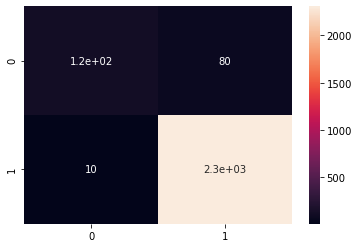

In [185]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot=True)

# Test data 

In [187]:
y_pred_test = NB_classifier.predict(X_test)

<AxesSubplot:>

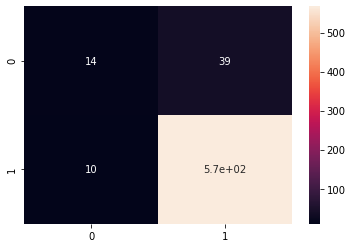

In [188]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True)

In [189]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.58      0.26      0.36        53
           1       0.94      0.98      0.96       577

    accuracy                           0.92       630
   macro avg       0.76      0.62      0.66       630
weighted avg       0.91      0.92      0.91       630



<a id='LR'></a>
# Logistic Regression
***

In [192]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [193]:
# Show model predictions 
y_pred = lr.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [195]:
print('Accuracy = {} %'.format(100 * accuracy_score(y_pred,y_test)))

Accuracy = 93.17460317460318 %


<AxesSubplot:>

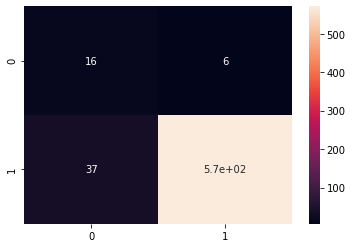

In [196]:
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True)

In [198]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.30      0.43        53
           1       0.94      0.99      0.96       577

    accuracy                           0.93       630
   macro avg       0.83      0.65      0.70       630
weighted avg       0.92      0.93      0.92       630



## Conclusion

- Note that this is an unbalanced data set so there are alot of classes that are positive which is why most data is classifed as correct 
- Wasn't satisfied with recall with class 0 being so low (find out what that means) NB
- Achieved much better precison on class 0. Overall LR predictions are better. 

# Stop End

<a id='RP'></a>
# Remove Punctuation 
***

In [83]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [89]:
# Define a function to remove punctuations
def remove_punc(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)

    return Test_punc_removed_join

In [90]:
# Remove punctuations from the dataset 
reviews_df['verified_reviews'] = reviews_df['verified_reviews'].apply(remove_punc)

In [93]:
# Check work

reviews_df['verified_reviews']

0                                            Love my Echo
1                                                Loved it
2       Sometimes while playing a game you can answer ...
3       I have had a lot of fun with this thing My 4 y...
4                                                   Music
                              ...                        
3145      Perfect for kids adults and everyone in between
3146    Listening to music searching locations checkin...
3147    I do love these things i have them running my ...
3148    Only complaint I have is that the sound qualit...
3149                                                 Good
Name: verified_reviews, Length: 3150, dtype: object

In [94]:
reviews_df['verified_reviews'][10]

'I sent it to my 85 year old Dad and he talks to it constantly'

<a id='RS'></a>
# Remove Stopwords

- Words that are too common and they don't really contribute to any sentiment when training ML models
***

In [92]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [95]:
# Add additional stopwords from nltk (looked throught data)

stop_words = stopwords.words('english')
stop_words.extend(['music','alexa','echo','amazon','device', 'product','dot',])

In [96]:
# Remove stopwords and remove short words (less than 2 characters)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):   # Take test data apply preprocessing to it and obtain tokens(indvidual words) from it
        if len(token) >= 2 and token not in stop_words:
            result.append(token)
            
    return result

In [100]:
# apply pre-processing to the text column
reviews_df['verified_reviews'] = reviews_df['verified_reviews'].apply(preprocess)
reviews_df['verified_reviews']

0                                                  [love]
1                                                 [loved]
2       [sometimes, playing, game, answer, question, c...
3       [lot, fun, thing, yr, old, learns, dinosaurs, ...
4                                                      []
                              ...                        
3145                    [perfect, kids, adults, everyone]
3146    [listening, searching, locations, checking, ti...
3147    [love, things, running, entire, home, tv, ligh...
3148    [complaint, sound, quality, isnt, great, mostl...
3149                                               [good]
Name: verified_reviews, Length: 3150, dtype: object

In [106]:
# join the words into one string
# Join all text together then add one space in between
reviews_df['verified_reviews'] = reviews_df['verified_reviews'].apply(lambda x: " ".join(x))
reviews_df

verified_reviews  feedback  Black  Dot  \
0                                                  love         1           0   
1                                                 loved         1           0   
2     sometimes playing game answer question correct...         1           0   
3     lot fun thing yr old learns dinosaurs control ...         1           0   
4                                                               1           0   
...                                                 ...       ...         ...   
3145                       perfect kids adults everyone         1           1   
3146  listening searching locations checking time lo...         1           1   
3147  love things running entire home tv lights ther...         1           1   
3148  complaint sound quality isnt great mostly use ...         1           0   
3149                                               good         1           1   

      Black  Plus  Black  Show  Black  Spot  Charcoal Fabric   \
0               0            0            0                 1   
1               0            0            0                 1   
2               0            0            0                 0   
3               0            0            0                 1   
4               0            0            0                 1   
...           ...          ...          ...               ...   
3145            0            0            0                 0   
3146            0            0            0                 0   
3147            0            0            0                 0   
3148            0            0            0                 0   
3149            0            0            0                 0   

      Configuration: Fire TV Stick  Heather Gray Fabric   Oak Finish   \
0                                0                     0            0   
1                                0                     0            0   
2                                0                     0            0   
3                                0                     0            0   
4                                0                     0            0   
...                            ...                   ...          ...   
3145                             0                     0            0   
3146                             0                     0            0   
3147                             0                     0            0   
3148                             0                     0            0   
3149                             0                     0            0   

      Sandstone Fabric   Walnut Finish   White  White  Dot  White  Plus  \
0                     0               0      0           0            0   
1                     0               0      0           0            0   
2                     0               1      0           0            0   
3                     0               0      0           0            0   
4                     0               0      0           0            0   
...                 ...             ...    ...         ...          ...   
3145                  0               0      0           0            0   
3146                  0               0      0           0            0   
3147                  0               0      0           0            0   
3148                  0               0      0           1            0   
3149                  0               0      0           0            0   

      White  Show  White  Spot  
0               0            0  
1               0            0  
2               0            0  
3               0            0  
4               0            0  
...           ...          ...  
3145            0            0  
3146            0            0  
3147            0            0  
3148            0            0  
3149            0            0  

[3150 rows x 17 columns]

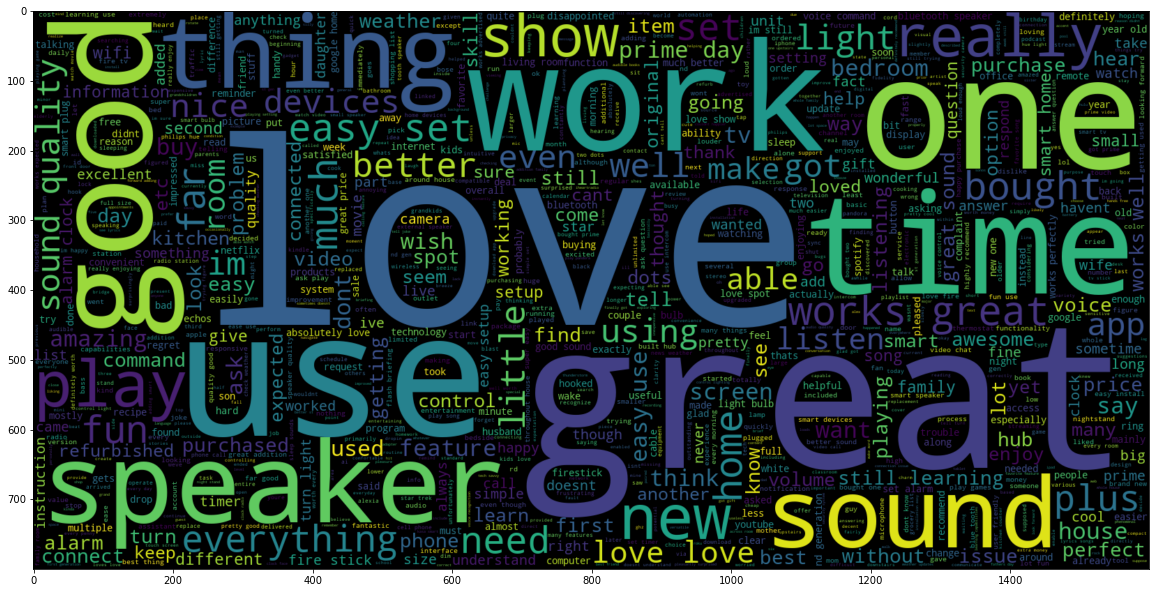

In [107]:
# plot the new version of word cloud for text with positive sentiment 
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(reviews_df[reviews_df['feedback'] == 1]['verified_reviews']))
plt.imshow(wc, interpolation = 'bilinear');

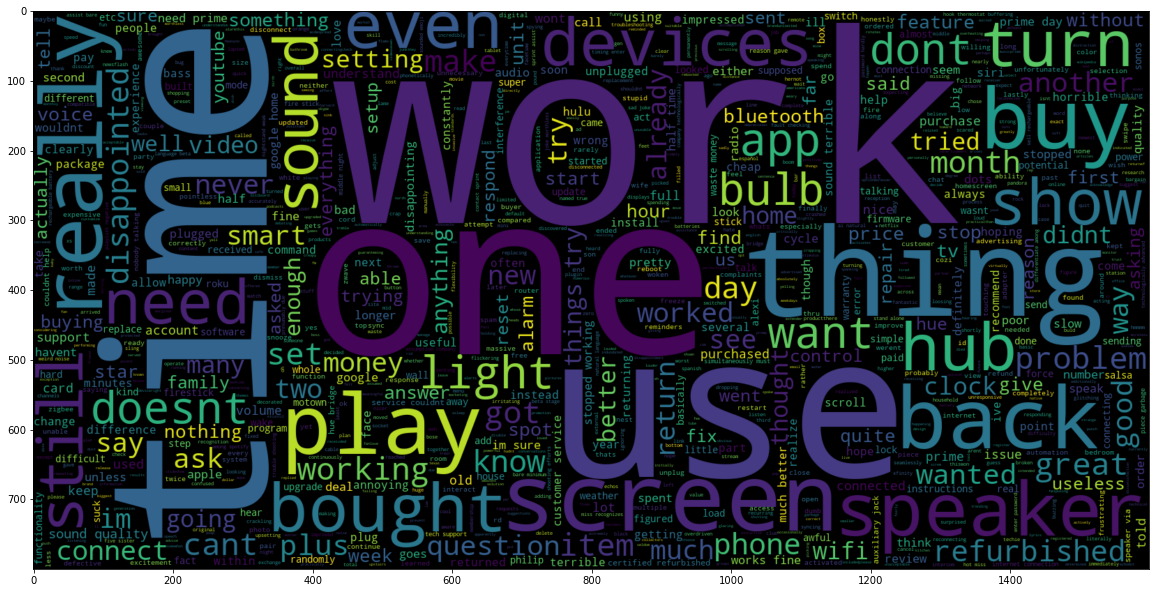

In [108]:
# plot the new version of word cloud for text with negative sentiment 
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(reviews_df[reviews_df['feedback'] == 0]['verified_reviews']))
plt.imshow(wc, interpolation = 'bilinear');

<a id='Token'></a>
# Perform Count Vectorization

- Tokenization: 
***